In [0]:
!pip install -U -q PyDrive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
#Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
file_list = drive.ListFile({'q': "'19I4LBwCe95ZjHneDQptskSpfP67UOsk3' in parents and trashed=false"}).GetList()

for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: auto-mpg.csv, id: 0B3iuBB_4YUyJTGFscmJWQWh5bFpYQm9HNlYza3NkU2tEUFBN


In [0]:
file_id='0B3iuBB_4YUyJTGFscmJWQWh5bFpYQm9HNlYza3NkU2tEUFBN'
file_name='auto-mpg.csv'

In [0]:
train_downloaded = drive.CreateFile({'id':file_id })
train_downloaded.GetContentFile(file_name) 

In [6]:
import pandas as pd
data = pd.read_csv(file_name,na_values=['NA','?'])
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


In [7]:
data.shape

(398, 9)

In [8]:
data.isnull().values.any()

True

In [9]:
data.isnull().sum()

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
year            0
origin          0
name            0
dtype: int64

In [14]:
df1 = data[data.isnull().any(axis=1)]
print (df1)

      mpg  cylinders  displacement  horsepower  weight  acceleration  year  \
32   25.0          4          98.0         NaN    2046          19.0    71   
126  21.0          6         200.0         NaN    2875          17.0    74   
330  40.9          4          85.0         NaN    1835          17.3    80   
336  23.6          4         140.0         NaN    2905          14.3    80   
354  34.5          4         100.0         NaN    2320          15.8    81   
374  23.0          4         151.0         NaN    3035          20.5    82   

     origin                  name  
32        1            ford pinto  
126       1         ford maverick  
330       2  renault lecar deluxe  
336       1    ford mustang cobra  
354       2           renault 18i  
374       1        amc concord dl  


In [0]:
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)

In [0]:
missing_median(data, 'horsepower')
data.drop('name',1,inplace=True)

In [18]:
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
0,18.0,8,307.0,130.0,3504,12.0,70,1
1,15.0,8,350.0,165.0,3693,11.5,70,1
2,18.0,8,318.0,150.0,3436,11.0,70,1
3,16.0,8,304.0,150.0,3433,12.0,70,1
4,17.0,8,302.0,140.0,3449,10.5,70,1


In [20]:
data.isnull().sum()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
year            0
origin          0
dtype: int64

In [21]:
data.shape

(398, 8)

In [0]:
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)

In [23]:
# Drop outliers in MPG
print("Length before MPG outliers dropped: {}".format(len(data)))
remove_outliers(data,'mpg',2)
print("Length after MPG outliers dropped: {}".format(len(data)))

Length before MPG outliers dropped: 398


NameError: ignored

In [0]:
import numpy as np

In [25]:
# Drop outliers in MPG
print("Length before MPG outliers dropped: {}".format(len(data)))
remove_outliers(data,'mpg',2)
print("Length after MPG outliers dropped: {}".format(len(data)))

Length before MPG outliers dropped: 398
Length after MPG outliers dropped: 388


In [26]:
data.shape

(388, 8)

In [0]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

In [0]:
preprocess = True

if preprocess:
  encode_text_dummy(data, 'origin')

In [29]:
data.shape

(388, 10)

In [30]:
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin-1,origin-2,origin-3
0,18.0,8,307.0,130.0,3504,12.0,70,1,0,0
1,15.0,8,350.0,165.0,3693,11.5,70,1,0,0
2,18.0,8,318.0,150.0,3436,11.0,70,1,0,0
3,16.0,8,304.0,150.0,3433,12.0,70,1,0,0
4,17.0,8,302.0,140.0,3449,10.5,70,1,0,0


In [0]:
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd

In [0]:
  encode_numeric_zscore(data,'mpg')
  encode_numeric_zscore(data,'cylinders')
  encode_numeric_zscore(data,'horsepower')
  encode_numeric_zscore(data,'weight')
  encode_numeric_zscore(data,'acceleration')
  encode_numeric_zscore(data,'displacement')

In [33]:
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin-1,origin-2,origin-3
0,-0.691361,1.469532,1.063827,0.647254,0.604084,-1.299996,70,1,0,0
1,-1.104856,1.469532,1.476309,1.566728,0.827841,-1.487212,70,1,0,0
2,-0.691361,1.469532,1.169346,1.172668,0.523579,-1.674429,70,1,0,0
3,-0.967024,1.469532,1.035050,1.172668,0.520028,-1.299996,70,1,0,0
4,-0.829193,1.469532,1.015864,0.909961,0.538970,-1.861645,70,1,0,0


In [0]:
# conventional way to import seaborn
import seaborn as sns;sns.set()

# allow plots to appear within the notebook
%matplotlib inline

import matplotlib.pyplot as plt

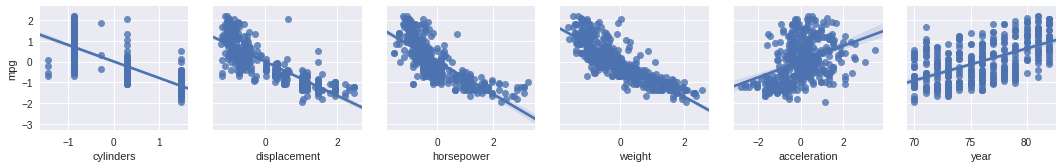

In [35]:
sns.pairplot(data, x_vars=['cylinders','displacement','horsepower','weight','acceleration','year'], y_vars='mpg', kind='reg')

In [0]:
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)

In [0]:
X,y = to_xy(data,'mpg')

In [0]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

X_train.shape,y_train.shape,X_test.shape,y_test.shape

((310, 9), (310, 1), (78, 9), (78, 1))

In [40]:
X_train.shape

(310, 9)

In [41]:
Xtrain.head()

NameError: ignored

In [0]:
from sklearn.linear_model import LinearRegression

In [0]:
# instantiate
linreg = LinearRegression()